In [104]:
library(RBGL)
library(ggplot2)
library(dplyr)

source("lib/code_for_binary_simulations/blip_vs_bidag_plot.R")
source("lib/code_for_binary_simulations/summarySE.R")

In [287]:
directory <- "simresults"

In [288]:
filenames <- list.files(pattern = "^(ROC_itsearch)", path = directory)
ROCdf_itsearch <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_itsearch <- dplyr::bind_rows(ROCdf_itsearch, tmpdf)
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


In [289]:
filenames <- list.files(pattern = "^(ROC_orderMCMC)", path = directory)
ROCdf_order_mcmc <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_order_mcmc <- dplyr::bind_rows(ROCdf_order_mcmc, tmpdf)
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


In [290]:
sumROC_order_mcmc = ROCdf_order_mcmc %>% 
                    group_by(algorithm, threshold) %>% 
                    summarise(TPR_mean = mean(TPR), 
                              TPR_median = median(TPR), 
                              FPRn_median = median(FPRn), 
                              TPR_q1 = quantile(TPR, probs = c(0.05)), 
                              TPR_q3 = quantile(TPR, probs = c(0.95)),
                              N = n())

In [291]:
filenames <- list.files(pattern = "^(ROC_pcalg)", path = directory)
roc_pcalg <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  roc_pcalg <- dplyr::bind_rows(roc_pcalg, tmpdf)
}

In [293]:
sum_roc_pcalg <- roc_pcalg %>% 
                 group_by(algorithm, alpha) %>% 
                 summarise(TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          N = n())

ERROR: Error: Column `alpha` is unknown


In [269]:
filenames <- list.files(pattern = "^(ROC_itsearch)", path = directory)
ROCdf_itsearch <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_itsearch <- dplyr::bind_rows(ROCdf_itsearch, tmpdf)
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


In [274]:
sum_roc_itsearch <- ROCdf_itsearch %>% 
                 group_by(algorithm) %>% 
                 summarise(TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          N = n())

In [279]:
filenames <- list.files(pattern = "^(ROC_blip)", path = directory)
ROCdf_blip <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_blip <- dplyr::bind_rows(ROCdf_blip, tmpdf)
}

In [281]:
sum_roc_blip <- ROCdf_blip %>% 
                 group_by(algorithm) %>% 
                 summarise(TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          N = n())

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



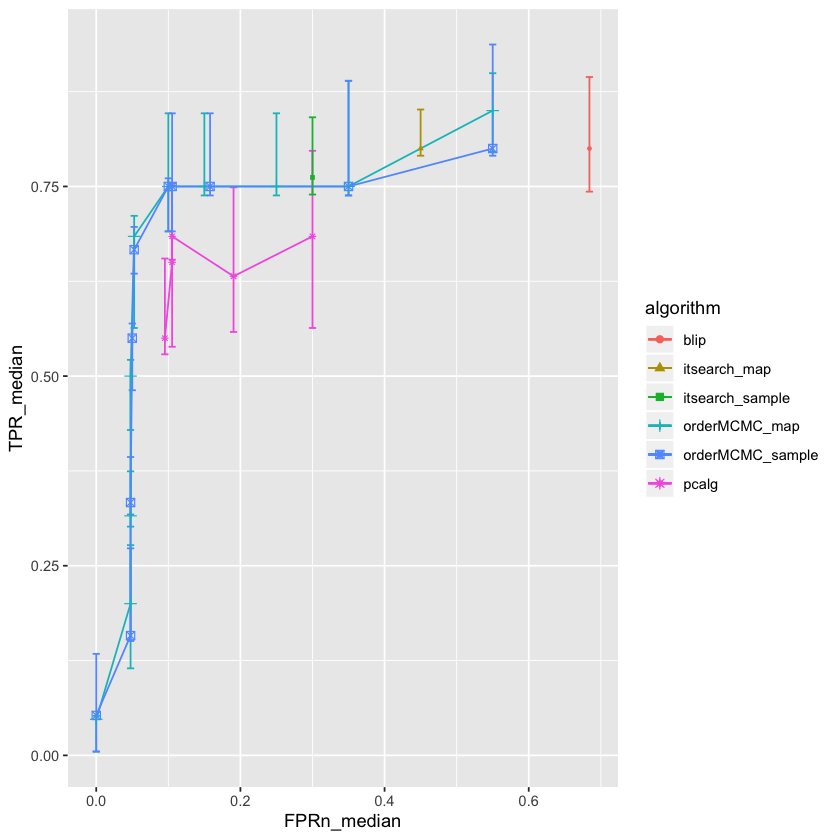

In [283]:
ggplot() +
# PC algorithm
geom_errorbar(data = sum_roc_pcalg,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_pcalg,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_pcalg,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) + 
## Order mcmc
geom_errorbar(data = sumROC_order_mcmc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sumROC_order_mcmc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sumROC_order_mcmc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 2) +
## Iterative search
geom_errorbar(data = sum_roc_itsearch,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_itsearch,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_itsearch,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) +
## Blip
geom_errorbar(data = sum_roc_blip,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_blip,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_blip,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) 